In [60]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

from tools import create_x_y

In [65]:
def encode_y(y):
    if len(set(y)) == 2:
        remap_dict = {-1: 0, 1: 1}
    elif len(set(y)) == 3:
        remap_dict = {-1: 0, 0: 1, 1: 2}
    elif len(set(y)) == 5:
        remap_dict = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    for i, val in enumerate(y):
        y[i] = remap_dict[val]

    return y


def weight_data(x):
    # least represented class is 1.0, others are percentage_least/percentage_other
    percentages = {}
    len_x = len(x)
    for uniq_val in set(x):
        percentages[uniq_val] = sum([1 for i in x if i == uniq_val]) / len_x
    least = min(percentages, key=percentages.get)
    weights = {i: percentages[least] / percentages[i] for i in percentages}
    return weights


# match feature importances from vector with multiple lagged vals of each column
def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }

    return imp

def save_importances_plot(fi, name, title):
    import seaborn as sns
    importances = importances_from_lag(fi, OTHER_COLS) 
    x_axis = list(importances.keys())
    y_axis = [float(i) for i in importances.values()]
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    sns.barplot(y=x_axis, x=y_axis).set_title(title)
    
    plt.savefig(f'../plots/{name}.pdf')

['open', 'high', 'low', 'close', 'vol', 'max_comp', 'max_neg', 'max_neu', 'max_pos', 'min_comp', 'min_neg', 'min_neu', 'min_pos', 'std_comp', 'std_neg', 'std_neu', 'std_pos', 'mean_comp', 'mean_neg', 'mean_neu', 'mean_pos', 'median_comp', 'median_neg', 'median_neu', 'median_pos', 'count', 'bin_3']


In [5]:
def measure_acc(x, y, binary=True):
    mode = "binary:logistic"
    if not binary:
        mode = "multi:softprob"
    clf = xgb.XGBClassifier(objective=mode, random_state=42)#, sample_weight=compute_sample_weight(weight_data(y), y))

    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.003, 0.3),  # default 0.1
        "max_depth": randint(2, 6),  # default 3
        "n_estimators": randint(100, 400),  # default 100
        "subsample": uniform(0.6, 0.4), 
    }
    time_split = TimeSeriesSplit(n_splits=5)
    xgb_search = RandomizedSearchCV(
        clf,
        param_distributions=params,
        random_state=42,
        n_iter=20,
        cv=time_split,
        verbose=1,
        n_jobs=4,
    )
    split = int(0.8 * len(x))
    xgb_search.fit(x[:split], y[:split])
    y_pred = xgb_search.predict(x[split:])
    cm = confusion_matrix(y[split:], y_pred)
    acc = sum(y_pred == y[split:]) / len(y_pred)
    fi = xgb_search.best_estimator_.feature_importances_

    return cm, acc, fi

In [ ]:
full_names = {
    "aapl": "Apple",
    "msft": "Microsoft",
    "tsla": "Tesla",
    "goog": "Google (GOOG)",
    "googl": "Google (GOOGL)",
}
acc = {}
cm = {}
for company in full_names.keys():
    df = pd.read_csv(f"../datasets/binned/{company}_binned.csv")
    VITAL_COLS = ["date_", "ticker", "bin_2", "diffs", "bin_5"]
    OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    print(OTHER_COLS)
    cm[company] = {}
    acc[company] = {}
    fi = {}
    for lag in [3, 6, 10, 16]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_3", lag=lag)
        y = encode_y(y)
        cm[company][lag], acc[company][lag], fi[lag] = measure_acc(x, y, binary=False)
        save_importances_plot(fi[lag], f"xgb_{company}_imp_{lag}", f"{full_names[company]} lag = {lag}")


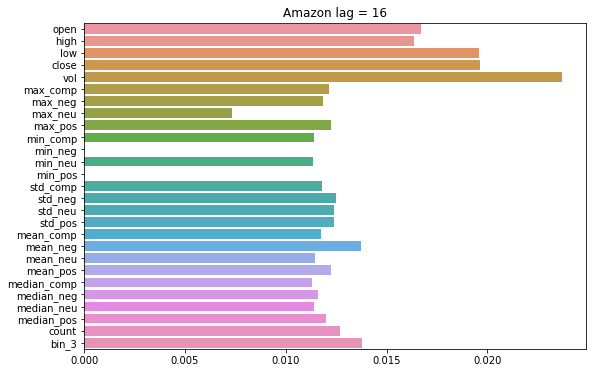